In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

['newdrivingdata']


In [2]:
print (os.listdir('../input/newdrivingdata/newdrivingdata/'))

['train', 'test', 'steering_angle.csv']


In [3]:
# building the model 
from keras.applications.resnet50 import ResNet50
conv_base = ResNet50(weights = 'imagenet',include_top=False,input_shape=(100,100,3))

Using TensorFlow backend.
/opt/conda/lib/python3.6/site-packages/keras_applications/resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


94658560/94653016 [==============================] - 1s 0us/step


In [4]:
conv_base.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 100, 100, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 106, 106, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 50, 50, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 50, 50, 64)   256         conv1[0][0]                      
__________________________________________________________________________________________________
activation

In [5]:
# freezing all layers upto 1st 15 blocks
conv_base.trainable = True

for layer in conv_base.layers[:45]:
  layer.trainable = False
  
for layer in conv_base.layers:
  print (layer , layer.trainable)

conv_base.summary()
  
  

<keras.engine.input_layer.InputLayer object at 0x7fbb7f8afcc0> False
<keras.layers.convolutional.ZeroPadding2D object at 0x7fbb7f7da9e8> False
<keras.layers.convolutional.Conv2D object at 0x7fbb7f6b6c18> False
<keras.layers.normalization.BatchNormalization object at 0x7fbb7f6b6dd8> False
<keras.layers.core.Activation object at 0x7fbb7f6b6f98> False
<keras.layers.convolutional.ZeroPadding2D object at 0x7fbb7f637b38> False
<keras.layers.pooling.MaxPooling2D object at 0x7fbb7f615278> False
<keras.layers.convolutional.Conv2D object at 0x7fbb7f65b828> False
<keras.layers.normalization.BatchNormalization object at 0x7fbb7c05f6d8> False
<keras.layers.core.Activation object at 0x7fbb7c05f780> False
<keras.layers.convolutional.Conv2D object at 0x7fbb7f676d68> False
<keras.layers.normalization.BatchNormalization object at 0x7fbb544bcb38> False
<keras.layers.core.Activation object at 0x7fbb54484ef0> False
<keras.layers.convolutional.Conv2D object at 0x7fbb54192780> False
<keras.layers.convolution

In [6]:
import keras
from keras import optimizers
from keras import layers
from keras.preprocessing import image
from keras.applications.imagenet_utils import preprocess_input
from keras.layers import Input, Dense, Activation, BatchNormalization, Flatten, Conv2D
from keras.layers import AveragePooling2D, MaxPooling2D, Dropout
from keras.models import Model
from keras.models import Sequential

model = Sequential()
model.add(conv_base)
''' 
here below we are adding an extra layer of avgpooling because resnet50 in keras=2.1.6 version has avgpooling built 
in the model itself but in keras= 2.2.0+ we it has been ommitted(dont know the reasons)so if i use the current keras
version and calculate the parameters after adding the FC(fully connected) layers it would be around 90millon+ but the
paper which im trying to implement had only 24million+ parameters after adding the FC layers.
'''
model.add(AveragePooling2D(4, 4))
model.add(Flatten())
model.add(Dense(512))
model.add(Activation('tanh'))
model.add(Dropout(0.5))
model.add(Dense(256))
model.add(Activation('tanh'))
model.add(Dropout(0.5))
model.add(Dense(64))
model.add(Activation('tanh'))
model.add(Dropout(0.5))
model.add(Dense(1))
adam = keras.optimizers.Adam(lr=1e-4, beta_1=0.9, beta_2=0.999, epsilon=1e-8, decay=1e-4/32, amsgrad=False)

model.compile(loss='mean_squared_error', optimizer=adam)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Model)             (None, 4, 4, 2048)        23587712  
_________________________________________________________________
average_pooling2d_1 (Average (None, 1, 1, 2048)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 2048)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               1049088   
_________________________________________________________________
activation_50 (Activation)   (None, 512)               0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 256)               131328    
__________

In [7]:
import pandas as pd
df = pd.read_csv('../input/newdrivingdata/newdrivingdata/steering_angle.csv', header = None)
print (df.head(3))
split_index = int(len(df)*0.8)
train_df = df[:split_index]
test_df = df[split_index:]
print (train_df.shape)
print (test_df.shape)

       0    1
0  0.jpg  0.0
1  1.jpg  0.0
2  2.jpg  0.0
(36324, 2)
(9082, 2)


In [8]:
train_df.columns = ["image","angle"]
test_df.columns = ['image','angle']
print (train_df.head(3))
print (test_df.head(3))

   image  angle
0  0.jpg    0.0
1  1.jpg    0.0
2  2.jpg    0.0
           image  angle
36324  36324.jpg -11.09
36325  36325.jpg -10.79
36326  36326.jpg -10.08


In [9]:
test_df = test_df.reset_index(drop=True)
test_df.head(3)

,image,angle
0,36324.jpg,-11.09
1,36325.jpg,-10.79
2,36326.jpg,-10.08


In [10]:
import numpy as np 
import math 
test_df.angle = np.deg2rad(test_df.angle)
train_df.angle = np.deg2rad(train_df.angle)
test_df.head(3)

/opt/conda/lib/python3.6/site-packages/pandas/core/generic.py:4405: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


,image,angle
0,36324.jpg,-0.193557
1,36325.jpg,-0.188321
2,36326.jpg,-0.175929


In [11]:
from keras.preprocessing.image import ImageDataGenerator

In [12]:
shift = 0.2
datagen = ImageDataGenerator(rescale = 1./255 , rotation_range = 5 , width_shift_range=shift, 
                             height_shift_range=shift,validation_split = 0.25)

In [13]:
train_generator=datagen.flow_from_dataframe(
    dataframe=train_df,
    directory="../input/newdrivingdata/newdrivingdata/train/",
    x_col="image",
    y_col="angle",
    has_ext=True,                                     
    subset="training",
    batch_size=32,
    seed=42,
    shuffle=True,
    class_mode="other",
    target_size=(100,100))






Found 27243 images.


In [14]:
valid_generator=datagen.flow_from_dataframe(
    dataframe=train_df,
    directory="../input/newdrivingdata/newdrivingdata/train/",
    x_col="image",
    y_col="angle",
    has_ext=True,                                     
    subset="validation",
    batch_size=1,
    seed=42,
    shuffle=True,
    class_mode="other",
    target_size=(100,100))



Found 9081 images.


In [15]:
STEP_SIZE_TRAIN=train_generator.n//train_generator.batch_size
STEP_SIZE_VALID=valid_generator.n//valid_generator.batch_size
model.fit_generator(generator=train_generator,
                    steps_per_epoch=STEP_SIZE_TRAIN,
                    validation_data=valid_generator,
                    validation_steps=STEP_SIZE_VALID,
                    epochs=30
)

Epoch 1/30
851/851 [==============================] - 508s 597ms/step - loss: 0.9250 - val_loss: 0.2186
Epoch 2/30
851/851 [==============================] - 479s 563ms/step - loss: 0.2287 - val_loss: 0.2128
Epoch 3/30
851/851 [==============================] - 478s 561ms/step - loss: 0.1841 - val_loss: 0.2471
Epoch 4/30
851/851 [==============================] - 481s 565ms/step - loss: 0.1540 - val_loss: 0.2653
Epoch 5/30
851/851 [==============================] - 489s 574ms/step - loss: 0.1683 - val_loss: 0.2093
Epoch 6/30
851/851 [==============================] - 487s 572ms/step - loss: 0.1194 - val_loss: 0.2108
Epoch 7/30
851/851 [==============================] - 488s 574ms/step - loss: 0.1092 - val_loss: 0.2558
Epoch 8/30
851/851 [==============================] - 469s 551ms/step - loss: 0.0998 - val_loss: 0.2280
Epoch 9/30
851/851 [==============================] - 467s 549ms/step - loss: 0.0926 - val_loss: 0.2082
Epoch 10/30
851/851 [==============================] - 467s 549m

In [16]:
model.evaluate_generator(generator = valid_generator , steps =STEP_SIZE_VALID )

0.2198545758238684

In [17]:
test_datagen = ImageDataGenerator(rescale = 1./255)
test_generator=test_datagen.flow_from_dataframe(
    dataframe=test_df,
    directory="../input/newdrivingdata/newdrivingdata/test/",
    x_col="image",
    y_col=None,
    has_ext=True,
    batch_size=1,
    seed=42,
    shuffle=False,
    class_mode=None,
    target_size=(100,100))

Found 9082 images.


In [18]:
test_generator.reset()
STEP_SIZE_TEST=test_generator.n//test_generator.batch_size
pred=model.predict_generator(test_generator,STEP_SIZE_TEST,verbose=1)

9082/9082 [==============================] - 195s 21ms/step


In [19]:
from keras import losses
mse = keras.losses.mean_squared_error(test_df.angle, pd.DataFrame(pred))


In [20]:
mse

<tf.Tensor 'Mean:0' shape=(9082,) dtype=float64>

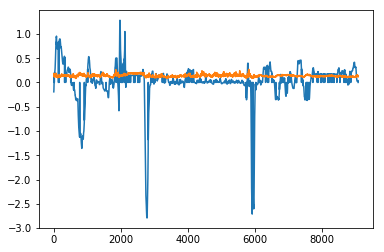

In [21]:
%matplotlib inline
import matplotlib.pyplot as plt

fig = plt.figure()
ax = plt.axes()

plt.plot(test_df.angle)
plt.plot(pred)